In [ ]:
import numpy as np
from scipy.integrate import simpson
from scipy.special import sici

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, viridis
from matplotlib.colors import LogNorm

from colossus.cosmology import cosmology as colossus_cosmo
from colossus.lss import mass_function,bias

from sashimi_c import halo_model 
hm=halo_model() # for the concentration-mass relation

from weak_lensing import *
c = cosmology()

1. Define mass, redshift and (comoving) wavenumber arrays or use those defined in the subhalo_params file

In [2]:
nk=100
nM=100
nz=10

k_grid = np.logspace(-5,3,nk) #1/Mpc
kmin = k_grid.min()
kmax = k_grid.max()
print(f'kmin = {kmin:.2e} 1/Mpc, kmax = {kmax:.2e} 1/Mpc')

M_grid = np.logspace(9, 16.0, nM) #Masses at z=0 in Msun
Mmin = M_grid.min()
Mmax = M_grid.max()
print(f'Mmin = {Mmin:.2e} Msun, Mmax = {Mmax:.2e} Msun')

z_grid = np.linspace(0.01,2.0,nz)
zmin = z_grid.min()
zmax = z_grid.max()
print(f'zmin = {zmin:.2f}, zmax = {zmax:.2f}')

kmin = 1.00e-05 1/Mpc, kmax = 1.00e+03 1/Mpc
Mmin = 1.00e+09 Msun, Mmax = 1.00e+16 Msun
zmin = 0.01, zmax = 2.00


In [4]:
data = np.load('subhalo_params004.npz')

k_grid = data['k_grid']
M_grid = data['M_grid']
z_grid = data['z_grid']

nk = len(k_grid) 
nM = len(M_grid)
nz = len(z_grid)

print("nk = ",nk)
print("nM = ",nM)
print("nz = ",nz)

m_mz  = data['m_mz']
I_kmz = data['I_kmz']
J_kmz = data['J_kmz']

nk=len(k_grid)
nM=len(M_grid)
nz=len(z_grid)

kmin = k_grid.min()
kmax = k_grid.max()
print(f'kmin = {kmin:.2e} 1/Mpc, kmax = {kmax:.2e} 1/Mpc')

zmin = z_grid.min()
zmax = z_grid.max()
print(f'zmin = {zmin:.2f}, zmax = {zmax:.2f}')

Mmin = M_grid.min()
Mmax = M_grid.max()
print(f'Mmin = {Mmin:.2e} Msun/h, Mmax = {Mmax:.2e} Msun/h')

nk =  100
nM =  10
nz =  10
kmin = 1.00e-05 1/Mpc, kmax = 1.00e+03 1/Mpc
zmin = 0.00, zmax = 2.00
Mmin = 1.00e+09 Msun/h, Mmax = 1.00e+17 Msun/h


2. Get the linear matter power spectrum from Colossus (and a non-Linear model out of the options by CAMB)

In [5]:
ps = power_spectrum(zmin=zmin, zmax=zmax,kmin=kmin+1e-8,kmax=kmax-1e-8)
logP_interp_colossus = ps.get_logPmm_interp()

kmin = 1.001e-05, kmax = 1.000e+03, chimin = 0.000e+00, chimax = 5.312e+03, zmin = 0.000, zmax = 2.000
Computed Pmm using Colossus


In [6]:
P_lin_zk = np.zeros((nz,nk),dtype=float)
for z_id,z in enumerate(z_grid):
    P_lin_zk[z_id,:] = np.exp(logP_interp_colossus((z, k_grid)))

In [9]:
if k_grid.max() > 1e3:
    k_camb= np.logspace(np.log10(k_grid.min()),3,nk)
else:
    k_camb = k_grid

ps_camb = power_spectrum(zmin=zmin, zmax=zmax,kmin=k_camb.min()+1e-8,kmax=k_camb.max()-1e-8,use_camb=True,nonLinear=True,nonlin_model='mead2020')
logP_interp_camb = ps_camb.get_logPmm_interp()

kmin = 1.001e-05, kmax = 1.000e+03, chimin = 0.000e+00, chimax = 5.312e+03, zmin = 0.000, zmax = 2.000
Note: redshifts have been re-sorted (earliest first)


Computed Pmm using CAMB


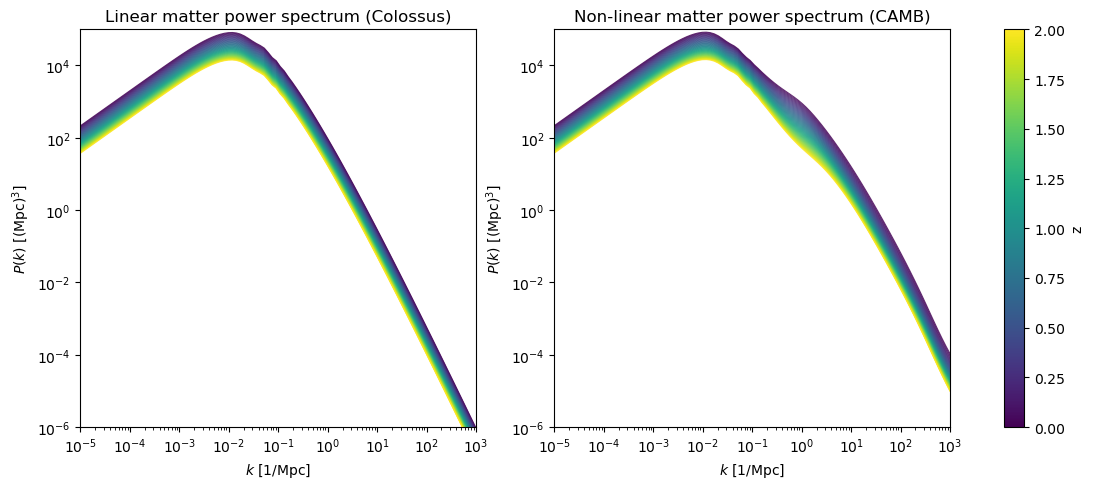

In [10]:
fig, ax = plt.subplots(1,2, figsize=(12, 5))
cmap = viridis
norm = Normalize(vmin=zmin, vmax=zmax)
z_plot = np.linspace(zmin, zmax, 50)

for z in z_plot:
    Pk = np.exp(logP_interp_colossus((z, k_grid)))
    ax[0].loglog(k_grid, Pk, color=viridis(norm(z)), lw=0.8, alpha=0.8)  
    Pk_camb = np.exp(logP_interp_camb((z, k_grid)))
    ax[1].loglog(k_grid, Pk_camb, color=viridis(norm(z)), lw=0.8, alpha=0.8)

ax[0].set_xlabel(r'$k\ [1/\mathrm{Mpc}]$')
ax[0].set_ylabel(r'$P(k)\ [(\mathrm{Mpc})^3]$')
ax[0].set_title('Linear matter power spectrum (Colossus)')
ax[0].set_xlim(kmin, kmax)
ax[0].set_ylim(1e-6, 1e5)
ax[1].set_xlim(kmin, kmax)
ax[1].set_ylim(1e-6, 1e5)
ax[1].set_xlabel(r'$k\ [1/\mathrm{Mpc}]$')
ax[1].set_ylabel(r'$P(k)\ [(\mathrm{Mpc})^3]$')
ax[1].set_title('Non-linear matter power spectrum (CAMB)')

plt.tight_layout()

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('z')
plt.show()

3. Get the mass function and halo bias from colossus, using the right mass definition: mdef='200c' and converting units correctly (Colossus expects Msun/h and Mpc/h). From this we can calculate $\rho_b(z) = \int_{Mmin}^{Mmax}Mn(M,z)b(M,z)dM$

In [ ]:
dndlnM_mz = np.zeros((nM,nz))
lnM = np.log(M_grid)

rho_comoving = c.rhocrit0 * c.OmegaM # Msun Mpc^-3

b_mz = np.zeros((nM,nz))

rho_m = np.zeros(nz)
rho_b = np.zeros(nz)

M_h = M_grid * c.h #Msun -> Msun/h

for z_id in range(nz):   
        
        dndlnM_mz[:,z_id] = mass_function.massFunction(M_h, z_grid[z_id], mdef='200c', model='tinker08', q_out='dndlnM') * c.h**3   # (Mpc/h)^-3 -> Mpc^-3
        rho_m[z_id] = simpson(M_grid * dndlnM_mz[:,z_id], lnM)

        b_mz[:,z_id] = bias.haloBias(M_h, z_grid[z_id], '200c', model = 'tinker10') 
        rho_b[z_id] = simpson(M_grid * b_mz[:,z_id] * dndlnM_mz[:,z_id], lnM)

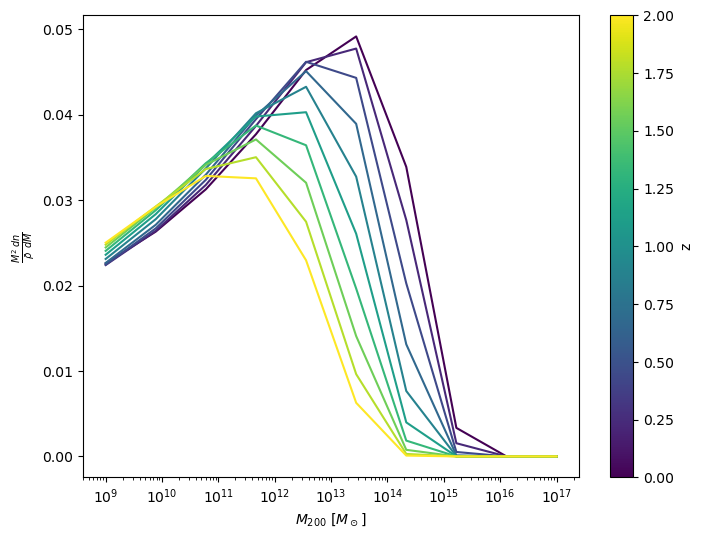

In [12]:
fig, ax = plt.subplots(figsize=(8,6))

norm = plt.Normalize(z_grid.min(), z_grid.max())
cmap = plt.cm.viridis

for z_id, z in enumerate(z_grid):
    ax.plot(
        M_grid,
        M_grid/rho_comoving*dndlnM_mz[:, z_id],
        color=cmap(norm(z))
    )

ax.set_xscale('log')
ax.set_yscale('linear')
ax.set_xlabel(r'$M_{200}$ $[M_\odot]$')
ax.set_ylabel(r'$\frac{M^2}{\bar{\rho}} \frac{dn}{dM}$ ')

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('z')

plt.show()

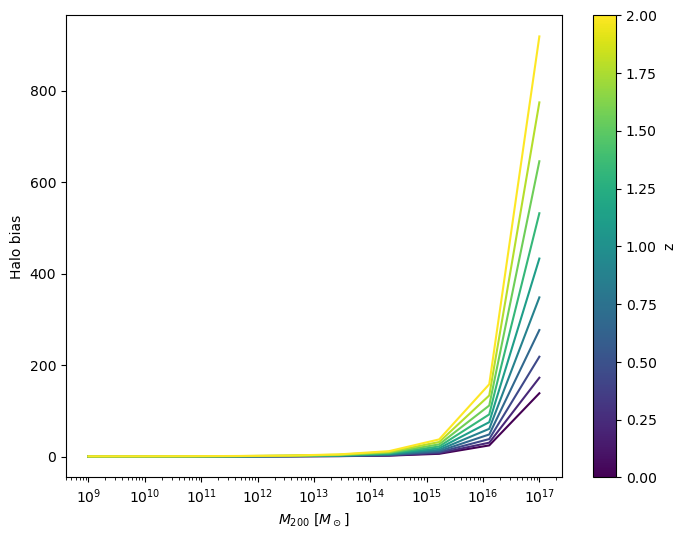

In [13]:
fig, ax = plt.subplots(figsize=(8,6))

norm = plt.Normalize(z_grid.min(), z_grid.max())
cmap = plt.cm.viridis

for z_id, z in enumerate(z_grid):
    ax.plot(
        M_grid,
        b_mz[:, z_id],
        color=cmap(norm(z))
    )

ax.set_xscale('log')
ax.set_yscale('linear')
ax.set_xlabel(r'$M_{200}$ $[M_\odot]$')
ax.set_ylabel('Halo bias')

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('z')

plt.show()

If all mass is enclosed in halos, $\bar{\rho} = \int_0^{\infty} M n(M) b(M) dM$. However, $\bar{\rho_b} = \int_{Mmin}^{Mmax} M n(M) b(M) dM<\bar{\rho}$ (for which we should account in the halo model)

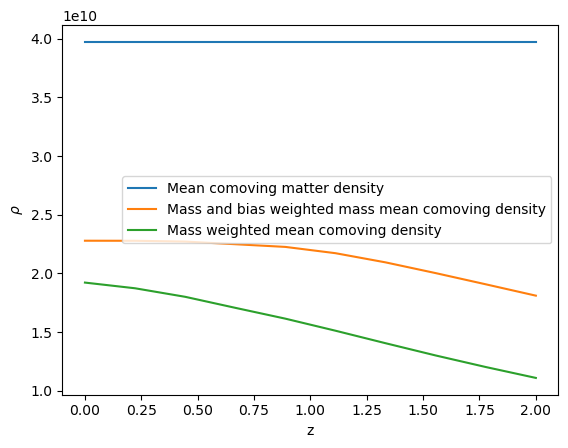

In [14]:
plt.plot(z_grid,np.ones_like(z_grid)*rho_comoving,label='Mean comoving matter density')
plt.plot(z_grid,rho_b,label='Mass and bias weighted mass mean comoving density')
plt.plot(z_grid,rho_m,label='Mass weighted mean comoving density')
plt.xlabel('z')
plt.ylabel(r'$\rho$')
plt.legend()

# Fourier Transform of the NFW Profile (M₍₂₀₀₎ Convention)

For a spherical NFW density profile,

$$
\rho(r) = \frac{\rho_s}{(r/r_s)\,(1 + r/r_s)^2},
$$

with scale radius $r_s$ and concentration $c = r_{200}/r_s$, the total mass inside $r_{200}$ is

$$
M_{200} = 4\pi \rho_s r_s^3 \left[\ln(1 + c) - \frac{c}{1 + c}\right].
$$

---

## Normalized Fourier Transform

The **mass-normalized** Fourier-space profile is defined as

$$
u(k|M_{200}) = \frac{1}{M_{200}} \int_0^{r_{200}} 4\pi r^2
\frac{\sin(kr)}{kr}\,\rho(r)\,dr,
$$

which has the analytic expression (Cooray & Sheth 2002; Scoccimarro et al. 2001):

$$
u(k|M_{200}) =
\frac{1}{\ln(1 + c) - \dfrac{c}{1 + c}}
\Bigg[
\cos(kr_s)\big[\mathrm{Ci}((1 + c)kr_s) - \mathrm{Ci}(kr_s)\big]
+ \sin(kr_s)\big[\mathrm{Si}((1 + c)kr_s) - \mathrm{Si}(kr_s)\big]
- \frac{\sin(c\,kr_s)}{(1 + c)\,kr_s}
\Bigg],
$$

where

$$
\mathrm{Si}(x) = \int_0^x \frac{\sin t}{t}\,dt, \quad
\mathrm{Ci}(x) = -\int_x^\infty \frac{\cos t}{t}\,dt.
$$

This function is **dimensionless and normalized** such that $u(k \to 0) = 1$.

In [18]:
def u_nfw(k, c, rs):
    """
    Analytical Fourier transform u(k|M_200) of an NFW halo.

    Parameters
    ----------
    k : float or array_like
        Wavenumber (1/Mpc)
    rs : float or array_like
        NFW scale radius (Mpc)
    c : float or array_like
        Concentration parameter (r_200 / r_s)

    Returns
    -------
    u : array_like
        Normalized Fourier-space NFW profile (u(0)=1).
        Shape: (len(k), len(rs)) if both are arrays
    """
    k  = np.atleast_1d(k).astype(float)
    rs = np.atleast_1d(rs).astype(float)
    c  = np.atleast_1d(c).astype(float)

    if rs.shape != c.shape:
        raise ValueError("rs and c must have the same shape")

    # Broadcast k against halo parameters
    x = k[:, None] * rs[None, :]

    denom = np.log(1.0 + c) - c / (1.0 + c)
    denom = denom[None, :]  # broadcast over k

    # sine and cosine integrals
    Si_x,  Ci_x  = sici(x)
    Si_xc, Ci_xc = sici((1.0 + c)[None, :] * x)

    u = (
        np.cos(x) * (Ci_xc - Ci_x)
        + np.sin(x) * (Si_xc - Si_x)
        - np.sin(c[None, :] * x) / ((1.0 + c)[None, :] * x)
    ) / denom

    # Return scalar if everything was scalar
    if u.shape == (1, 1):
        return u[0, 0]
    return u

def u_nfw_num(k, c, rs, Nr=2000):
    """
    Numerical Fourier transform of the NFW density profile.

    Parameters
    ----------
    k : float or array_like
        Wavenumber (1/Mpc)
    rs : float or array_like
        NFW scale radius (Mpc)
    c : float or array_like
        Concentration parameter (r_200 / r_s)
    Nr : int
        Number of radial integration points

    Returns
    -------
    u : array_like
        Normalized Fourier-space NFW profile (u(0)=1).
        Shape: (len(k), len(rs)) if both are arrays
    """

    k  = np.atleast_1d(k).astype(float)
    c  = np.atleast_1d(c).astype(float)
    rs = np.atleast_1d(rs).astype(float)

    if c.shape != rs.shape:
        raise ValueError("c and rs must have the same shape")

    nk = k.size
    nh = rs.size

    u = np.empty((nk, nh), dtype=float)

    for j in range(nh):
        rt = c[j] * rs[j]

        # Radial grid for this halo
        r = np.logspace(-6, np.log10(rt), Nr)

        x = r / rs[j]
        rho = 1.0 / (x * (1.0 + x)**2)

        # Mass normalization
        M = np.trapezoid(4.0 * np.pi * r**2 * rho, r)

        kr = np.outer(k, r)  # (nk, Nr)

        # sinc(kr) with safe k→0 limit
        sinc = np.ones_like(kr)
        mask = kr != 0.0
        sinc[mask] = np.sin(kr[mask]) / kr[mask]

        integrand = 4.0 * np.pi * r[None, :]**2 * rho[None, :] * sinc
        u[:, j] = np.trapezoid(integrand, r, axis=1) / M

    if u.shape == (1, 1):
        return u[0, 0]

    return u

## pyccl NFW profile calculation

$ \rho(r) = \frac{\rho_0}
       {\frac{r}{r_s}\left(1+\frac{r}{r_s}\right)^2}$

where $r_s$ is related to the comoving spherical overdensity halo radius $r_\Delta(M)$ through the concentration parameter $c(M)$ as

$ r_\Delta(M) = c(M) r_s $

and the normalization $\rho_0$ is

$\rho_0 = \frac{M}{4\pi r_s^3\,[\log(1+c) - c/(1+c)]}$

By default, this profile is truncated at $r = r_\Delta(M)$.

In nfw.py -> _fourier_analytic:

        # Comoving virial radius

        R_M = self.mass_def.get_radius(cosmo, M_use, a) / a

        c_M = self.concentration(cosmo, M_use, a)
        
        R_s = R_M / c_M

In mass_def.py:

 Halo masses are defined in terms of an overdensity
    parameter $\Delta$ and an associated density $X$ (either the
    matter density or the critical density)

-> get_radius:

$ R_\Delta = \left(\frac{3 M_\Delta}{4 \pi \rho_X \Delta}\right)^{1/3}$ 

halo radius in units of Mpc (physical, not comoving).

rho_x(a, species, *, is_comoving=False): Physical density of a given species at a scale factor, in units of 𝑀⊙/M⁢p⁢c3

## My code
The physical radius of a halo of mass $M_{200}$ at redshift z is:
$$r_{200}^{phys} = \left(\frac{3M_{200}}{4 \pi \rho_c(z) 200 }\right)^{1/3}$$

The comoving radius is:
$$r_{200}^{com} = \left(\frac{3M_{200}}{4 \pi \rho_c(z) 200 }\right)^{1/3}(1+z)$$


The halo model integrates over $M/\bar{\rho_m}$, where $\bar{\rho_m}=\Omega_m \rho_{c,0}$ is the comoving mean matter density. The density profile in the integral is a function of the comoving wavenumber $k$ and should be defined for halos of mass $M$ with comoving radius $r$ and a concentration parameter $c(M,z)$ that explicitely models the redshift-dependent halo concentration. The input parameters of my NFW profile are:

1. An array of comoving wavenumbers $k$

2. The concentration parameter from Correa et al $c_{200}(M_{200},z)$

3. The comoving scale radius $r_s = r_{200}^{com} / c_{200} $

In [37]:
def c200_r200_rs(M,z,hm):
    Mz = hm.Mzi(M,z)
    c200 = hm.conc200(Mz,z)
    r200 = (3.*M/(4.*np.pi*c.rhocrit(z)*200.))**(1./3.)*(1+z) 
    rs = r200/c200 
    return c200, r200, rs

In [32]:
def c200_r200_rs_duffy(M, z):
    # --- Duffy et al. 2008 parameters (200c, full sample) ---
    A = 5.71
    B = -0.084
    C = -0.47
    Mpivot = 2e12 / c.h  # Msun

    c200 = A * (M / Mpivot)**B * (1. + z)**C
    r200 = (3.*M/(4.*np.pi*c.rhocrit(z)*200.))**(1./3.)*(1+z) 
    rs = r200/c200 
    return c200, r200, rs

Text(0.5, 1.0, 'Physical (dotted) vs comoving (solid) r200')

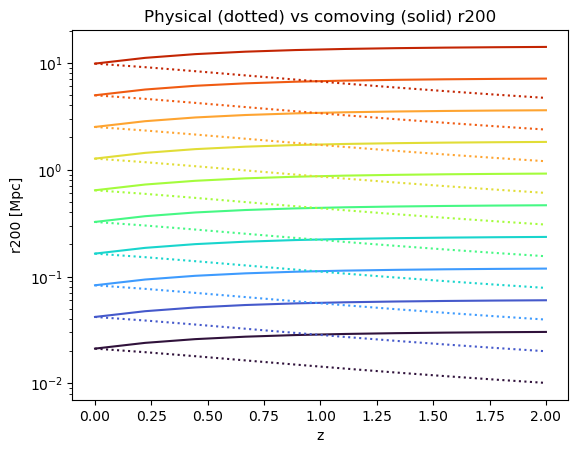

In [65]:
for M_id in range(nM):
    M = M_grid[M_id]
    r200_phys = (3.*M/(4.*np.pi*c.rhocrit(z_grid)*200.))**(1./3.)
    r200_com = (3.*M/(4.*np.pi*c.rhocrit(z_grid)*200.))**(1./3.)*(1+z_grid) 

    plt.plot(z_grid,r200_phys,':',color = plt.cm.turbo(M_id/nM))
    plt.plot(z_grid,r200_com,'-',color = plt.cm.turbo(M_id/nM))

plt.xlabel('z')
plt.ylabel('r200 [Mpc]')
plt.yscale('log')
plt.title('Physical (dotted) vs comoving (solid) r200')

In [38]:
u_kmz = np.zeros((nk,nM,nz),dtype=float)
for z_id,z in enumerate(z_grid):
    for M_id,M in enumerate(M_grid):
        c200, r200, rs = c200_r200_rs(M,z,hm)
        u_kmz[:,M_id,z_id] = u_nfw(k_grid, c200, rs)[:,0]

In [20]:
u_kmz_num = np.zeros((nk,nM,nz),dtype=float)
for z_id,z in enumerate(z_grid):
    for M_id,M in enumerate(M_grid):
        c200, r200, rs = c200_r200_rs(M,z,hm)
        u_kmz_num[:,M_id,z_id] = u_nfw_num(k_grid, c200, rs)[:,0]

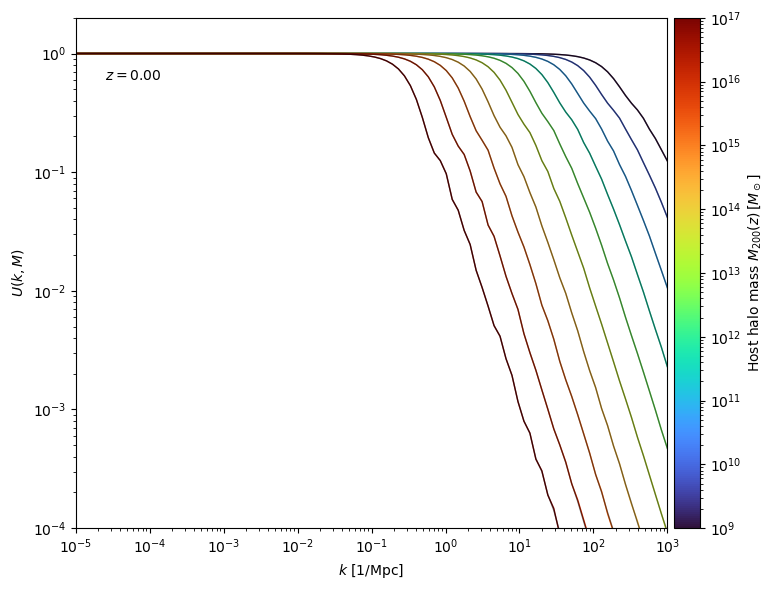

In [21]:
z_id = 0
fig, ax = plt.subplots(figsize=(8,6))
norm = LogNorm(vmin=M_grid.min(), vmax=M_grid.max())
cmap = plt.cm.turbo

for M_id,M in enumerate(M_grid):
    ax.loglog(
        k_grid,
        u_kmz[:,M_id,z_id],
        color=cmap(norm(M)),
        lw=1
    )
    ax.loglog(
        k_grid,
        u_kmz_num[:,M_id,z_id],
        color='black',
        lw=1,
        alpha = 0.5,
    )

ax.set_xlabel(r'$k\ [1/\mathrm{Mpc}]$')
ax.set_ylabel(r'$U(k,M)$')
ax.set_xlim(kmin, kmax)
ax.set_ylim(1e-4, 2e0)

ax.text(
        0.05, 0.90,
        rf'$z={z_grid[z_id]:.2f}$',
        transform=ax.transAxes,
        ha='left',
        va='top'
)

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.01)
cbar.set_label(r'Host halo mass $M_{200}(z)\,[M_\odot]$')

plt.tight_layout()
plt.show()

Now, we calculate the 1- and 2-halo terms of the halo model

In [23]:
P_1h = np.zeros((nz,nk))

for z_id, z in enumerate(z_grid):
    for k_id, k in enumerate(k_grid):
        integrand = ( M_grid / rho_comoving ) **2 * dndlnM_mz[:,z_id] * u_kmz[k_id,:,z_id]**2
        P_1h[z_id,k_id] = simpson(integrand,lnM)

P_2h = np.zeros((nz,nk))

for z_id, z in enumerate(z_grid):
    for k_id, k in enumerate(k_grid):
        b = b_mz[:,z_id]
        Plin = P_lin_zk[z_id,k_id]
        integrand =  ( M_grid / rho_comoving ) * dndlnM_mz[:,z_id]  * b * u_kmz[k_id,:,z_id]
        integral = simpson(integrand, lnM)
        P_2h[z_id,k_id] = Plin * integral**2

P_hh_total = P_1h + P_2h

In [ ]:
## Includes Mmin correction (Mead and Verde, ‘Including Beyond-Linear Halo Bias in Halo Models’. appendix A)
P_1h = np.zeros((nz,nk))

for z_id, z in enumerate(z_grid):
    for k_id, k in enumerate(k_grid):
        integrand = ( M_grid / rho_comoving ) **2 * dndlnM_mz[:,z_id] * u_kmz[k_id,:,z_id]**2
        P_1h[z_id,k_id] = simpson(integrand,lnM) + Mmin / rho_comoving / b_mz[0,z_id] * u_kmz[k_id,0,z_id]**2 * (1 - rho_b[z_id] / rho_comoving) 

P_2h = np.zeros((nz,nk))

for z_id, z in enumerate(z_grid):
    for k_id, k in enumerate(k_grid):
        b = b_mz[:,z_id]
        Plin = P_lin_zk[z_id,k_id]
        integrand =  ( M_grid / rho_comoving ) * dndlnM_mz[:,z_id]  * b * u_kmz[k_id,:,z_id]
        integral = simpson(integrand, lnM)
        P_2h[z_id,k_id] = Plin * (integral + u_kmz[k_id,0,z_id] * (1 - rho_b[z_id] / rho_comoving) )**2

P_hh_total = P_1h + P_2h

In [ ]:
## One halo suppression at large scales (Mead et al., ‘HMcode-2020’. eq. 17)
def one_halo_suppression(k, k_star):
    return (k / k_star)**4 / (1.0 + (k / k_star)**4)

sigma8_z = [c.sigma8(P_hh_total[i,:],k_grid) for i in range(nz)]

k_star = 0.05618 * np.array(sigma8_z)**(-1.013) * c.h # 1/Mpc

for z_id in range(nz):
    P_1h[z_id,:] *= one_halo_suppression(k_grid, k_star[z_id])

P_hh_total = P_1h + P_2h

In [ ]:
# Transition smoothing (Mead et al., ‘HMcode-2020’. eq. 23) (Doesn't seem to do much in my case)
Delta_1h = k_grid**3 / (2 * np.pi**2) * P_1h
Delta_2h = k_grid**3 / (2 * np.pi**2) * P_2h

for z_id in range(nz):
    R_sima_z = c.find_Rsigma(P_hh_total[z_id,:], k_grid)
    neff_z = c.neff_at_R(R_sima_z, P_hh_total[z_id,:], k_grid)
    alpha_z = 1.875 * (1.603)**(neff_z)
    print(f'z={z_grid[z_id]:.2f}, R_sigma={R_sima_z:.2f} Mpc, n_eff={neff_z:.2f}, alpha={alpha_z:.2f}')
    Delta_hh_total = (Delta_1h[z_id,:]**alpha_z + Delta_2h[z_id,:]**alpha_z)**(1/alpha_z)
    P_hh_total[z_id,:] = Delta_hh_total * (2 * np.pi**2) / k_grid**3

z=0.00, R_sigma=10.38 Mpc, n_eff=-1.45, alpha=0.95
z=0.22, R_sigma=8.70 Mpc, n_eff=-1.46, alpha=0.94
z=0.44, R_sigma=7.31 Mpc, n_eff=-1.48, alpha=0.93
z=0.67, R_sigma=6.10 Mpc, n_eff=-1.53, alpha=0.91
z=0.89, R_sigma=5.18 Mpc, n_eff=-1.46, alpha=0.94
z=1.11, R_sigma=4.38 Mpc, n_eff=-1.60, alpha=0.88
z=1.33, R_sigma=3.74 Mpc, n_eff=-1.54, alpha=0.91
z=1.56, R_sigma=3.21 Mpc, n_eff=-1.70, alpha=0.84
z=1.78, R_sigma=2.75 Mpc, n_eff=-1.60, alpha=0.88
z=2.00, R_sigma=2.37 Mpc, n_eff=-1.60, alpha=0.88


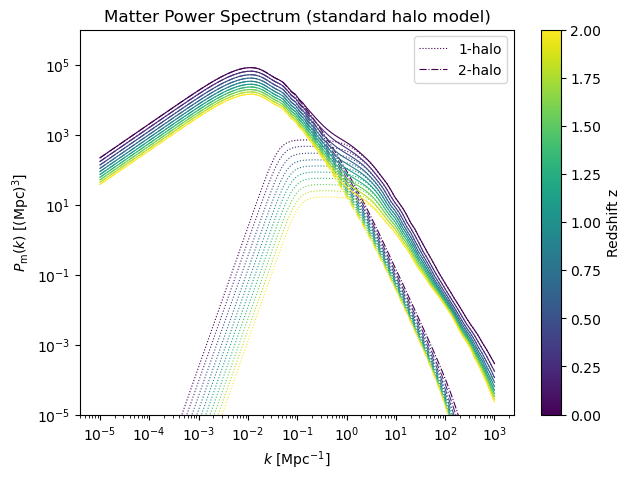

In [28]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_title('Matter Power Spectrum (standard halo model)')
ax.set_xlabel(r'$k\ [{\rm Mpc}^{-1}]$')
ax.set_ylabel(r'$P_{\rm m}(k)$ [$(\mathrm{Mpc})^3$]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-5,1e6)

# Colormap for redshift
cmap = viridis
norm = Normalize(vmin=np.min(z_grid), vmax=np.max(z_grid))

for i,z in enumerate(z_grid):
    ax.plot(k_grid, P_hh_total[i,:], color=cmap(norm(z)), lw=0.8)
    ax.plot(k_grid, P_1h[i,:], ls=':', color=cmap(norm(z)), lw=0.8, label='1-halo')
    ax.plot(k_grid, P_2h[i,:], ls='-.', color=cmap(norm(z)), lw=0.8, label='2-halo')
    if i==0:
        ax.legend()

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # required for ScalarMappable
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Redshift z')

plt.show()

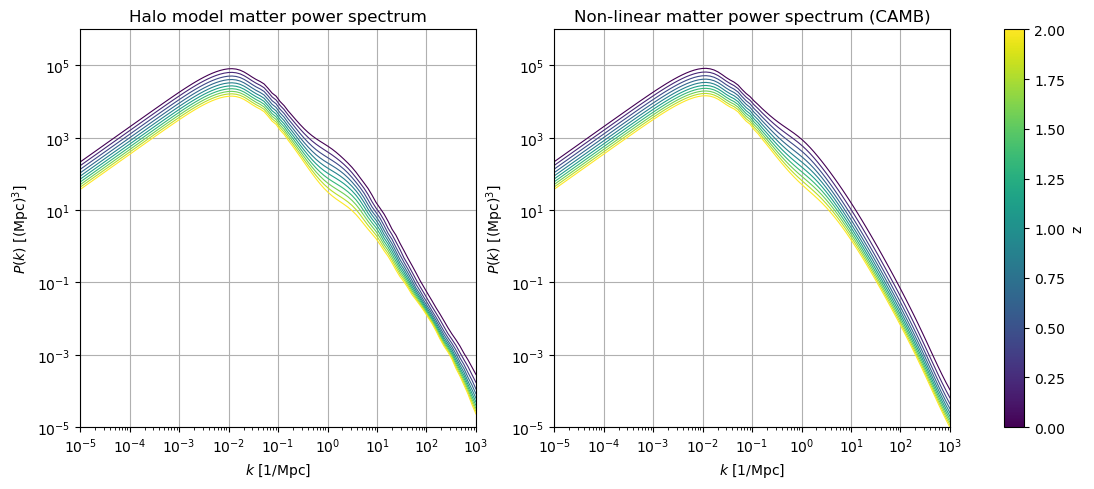

In [29]:
fig, ax = plt.subplots(1,2, figsize=(12, 5))
cmap = viridis
norm = Normalize(vmin=zmin, vmax=zmax)

for z_id,z in enumerate(z_grid):
    ax[0].loglog(k_grid, P_hh_total[z_id,:], color=viridis(norm(z)), lw=0.8)  
    Pk_camb = np.exp(logP_interp_camb((z, k_camb)))
    ax[1].loglog(k_camb, Pk_camb, color=viridis(norm(z)), lw=0.8)

ax[0].set_xlabel(r'$k\ [1/\mathrm{Mpc}]$')
ax[0].set_ylabel(r'$P(k)\ [(\mathrm{Mpc})^3]$')
ax[0].set_title('Halo model matter power spectrum')
ax[0].set_xlim(kmin, kmax)
ax[0].set_ylim(1e-5, 1e6)
ax[0].grid()

ax[1].set_xlim(kmin, kmax)
ax[1].set_ylim(1e-5, 1e6)
ax[1].set_xlabel(r'$k\ [1/\mathrm{Mpc}]$')
ax[1].set_ylabel(r'$P(k)\ [(\mathrm{Mpc})^3]$')
ax[1].set_title('Non-linear matter power spectrum (CAMB)')
ax[1].grid()

plt.tight_layout()

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('z')
plt.show()

In [30]:
np.savez('standard_halo_model_power_spectra005.npz', k=k_grid, z=z_grid, P_1h=P_1h, P_2h=P_2h,P_hh_total =P_hh_total)

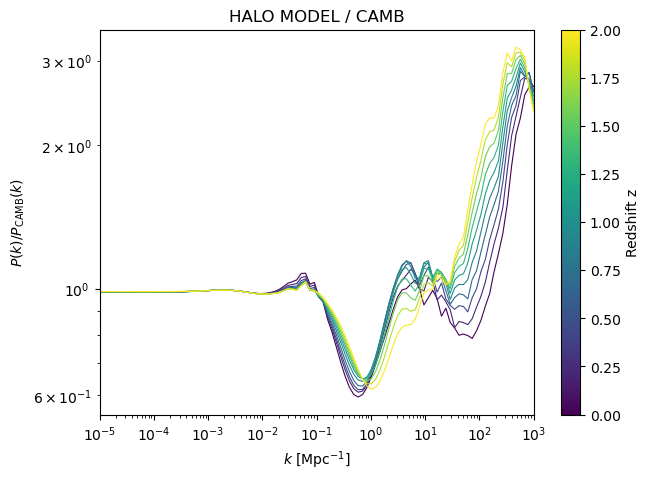

In [41]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_title('HALO MODEL / CAMB')
ax.set_xlabel(r'$k\ [{\rm Mpc}^{-1}]$')
ax.set_ylabel(r'$P(k)/P_{\rm CAMB}(k)$')
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim(-2,2)
ax.set_xlim(k_camb.min(),k_camb.max())

# Colormap for redshift
cmap = viridis
norm = Normalize(vmin=np.min(z_grid), vmax=np.max(z_grid))

for i,z in enumerate(z_grid):
    Pk_camb = np.exp(logP_interp_camb((z, k_grid)))
    ax.plot(k_grid, P_hh_total[i,:]/Pk_camb, color=cmap(norm(z)), lw=0.8)

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # required for ScalarMappable
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Redshift z')

plt.show()

# Subhalo model

In [22]:
m_min = 1e20
m_max = 0
for z_id in range(nz):
    for M_id in range(nM):
        m_min1 = m_mz[M_id][z_id].min()
        m_max1 = m_mz[M_id][z_id].max()
        if m_min1 < m_min:
            m_min = m_min1
        if m_max1 > m_max:
            m_max = m_max1

print(f'min subhalo mass = {m_min:.2e} Msun')
print(f'max subhalo mass = {m_max:.2e} Msun')

min subhalo mass = 8.47e+07 Msun
max subhalo mass = 4.29e+16 Msun


1. Get the I(k,z,M) and J(k,z,M) functions from the file

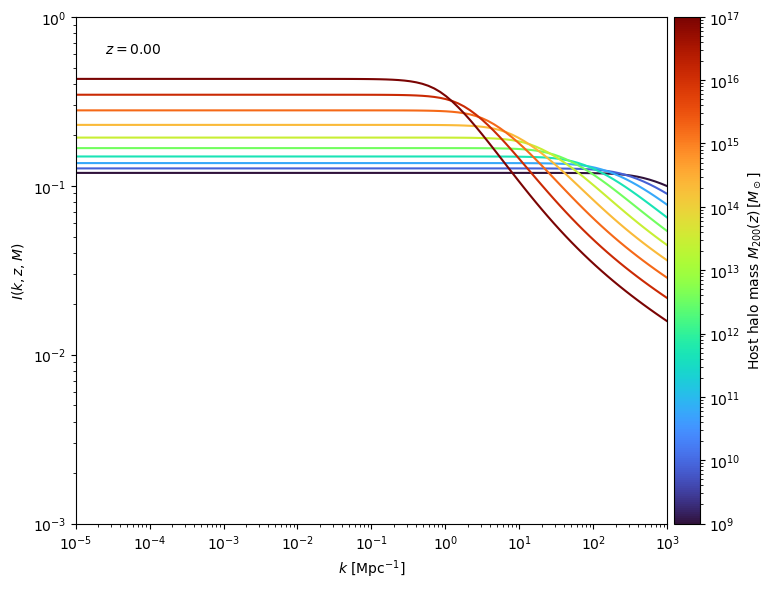

In [42]:
z_id = 0

cmap = plt.cm.turbo
norm = LogNorm(vmin=M_grid.min(), vmax=M_grid.max())

fig, ax = plt.subplots(figsize=(8,6))
for M_id in range(nM):
    I = I_kmz[:,M_id,z_id]
    color = cmap(norm(M_grid[M_id]))
    ax.loglog(k_grid,I, color=color)

ax.set_ylabel(r'$I(k,z,M)$')
ax.set_xlabel(r'$k\ [\mathrm{Mpc}^{-1}]$')

ax.text(
        0.05, 0.95,
        rf'$z={z_grid[z_id]:.2f}$',
        transform=ax.transAxes,
        ha='left',
        va='top'
)

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.01)
cbar.set_label(r'Host halo mass $M_{200}(z)\,[M_\odot]$')

ax.set_xlim(kmin,kmax)
ax.set_ylim(1e-3,1)
plt.tight_layout()
plt.show()

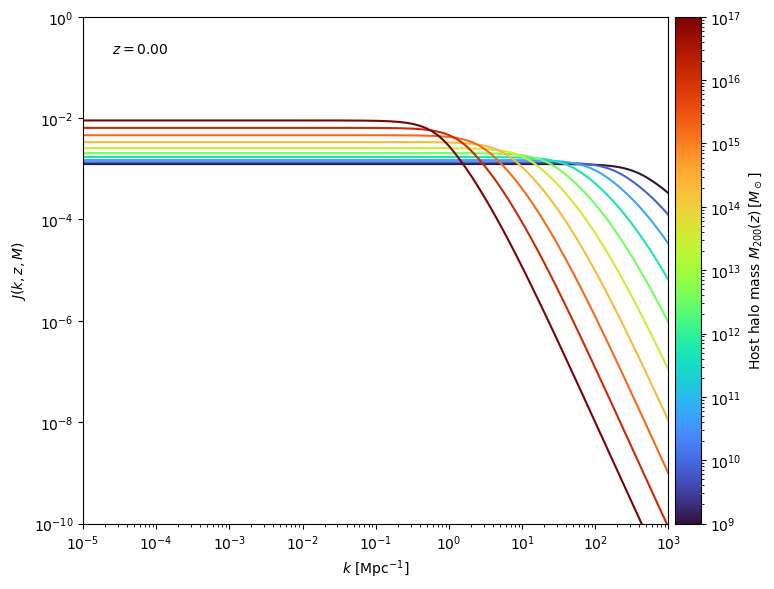

In [43]:
z_id = 0

cmap = plt.cm.turbo
norm = LogNorm(vmin=M_grid.min(), vmax=M_grid.max())

fig, ax = plt.subplots(figsize=(8,6))
for M_id in range(nM):
    J = J_kmz[:,M_id,z_id]
    color = cmap(norm(M_grid[M_id]))
    ax.loglog(k_grid,J, color=color)

ax.set_ylabel(r'$J(k,z,M)$')
ax.set_xlabel(r'$k\ [\mathrm{Mpc}^{-1}]$')

ax.text(
        0.05, 0.95,
        rf'$z={z_grid[z_id]:.2f}$',
        transform=ax.transAxes,
        ha='left',
        va='top'
)

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.01)
cbar.set_label(r'Host halo mass $M_{200}(z)\,[M_\odot]$')

ax.set_xlim(kmin,kmax)
ax.set_ylim(1e-10,1)
plt.tight_layout()
plt.show()

2. Get the subhalo fraction $f_{sub}(z)$ and use this to define a smooth mass array $M_{sm} = M(1-f_{sub}(z))$

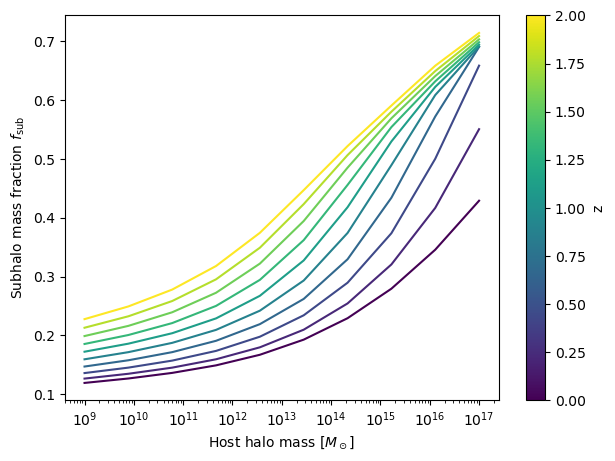

In [44]:
fig, ax = plt.subplots(figsize=(7,5))
fsh_list = np.empty((nM,nz))

ax.set_xscale('log')
ax.set_xlabel(r'Host halo mass $[M_\odot]$')
ax.set_ylabel(r'Subhalo mass fraction $f_{\mathrm{sub}}$')
# Colormap for redshift
cmap = viridis
norm = Normalize(vmin=np.min(z_grid), vmax=np.max(z_grid))

for i,z in enumerate(z_grid):
    fsh_list[:,i] = np.array(m_mz[:,i]/hm.Mzi(M_grid,z))
    ax.plot(M_grid,fsh_list[:,i], color=cmap(norm(z)))

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # required for ScalarMappable
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('z')

plt.show()

In [82]:
Msm_grid = np.zeros((nM,nz))

for M_id in range(nM):
    for z_id in range(nz):
        fsh = fsh_list[M_id,z_id]
        Msm_grid[M_id,z_id] = M_grid[M_id]*(1-fsh)

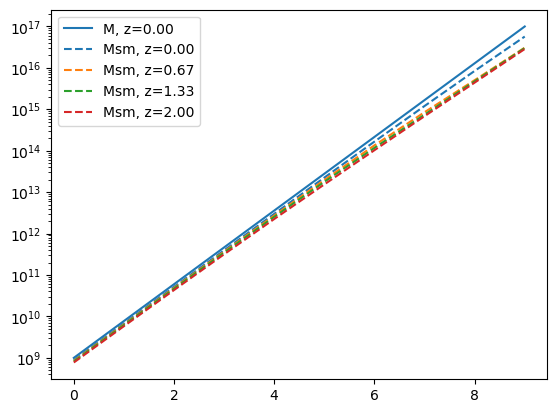

In [83]:
plt.plot(np.arange(nM),M_grid,label=f'M, z={z_grid[0]:.2f}',color = 'C0')
plt.plot(np.arange(nM),Msm_grid[:,0],label=f'Msm, z={z_grid[0]:.2f}',color = 'C0', ls = '--')
plt.plot(np.arange(nM),Msm_grid[:,4],label=f'Msm, z={z_grid[3]:.2f}',color = 'C1', ls = '--')
plt.plot(np.arange(nM),Msm_grid[:,6],label=f'Msm, z={z_grid[6]:.2f}',color = 'C2', ls = '--')
plt.plot(np.arange(nM),Msm_grid[:,9],label=f'Msm, z={z_grid[9]:.2f}',color = 'C3', ls = '--')
plt.yscale('log')
plt.legend()

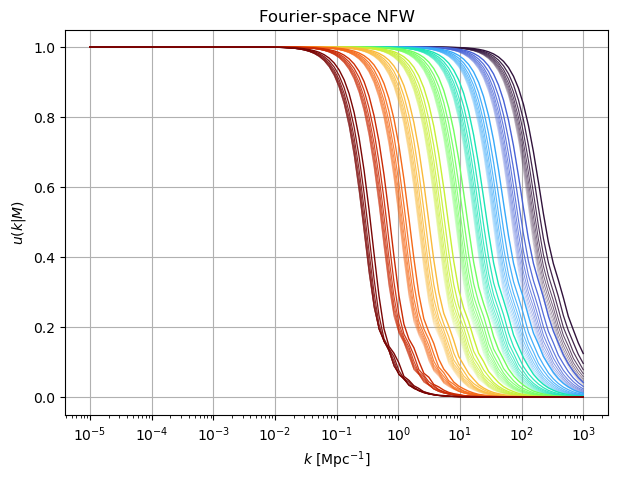

In [47]:
fig, ax = plt.subplots(figsize=(7,5))
colors = plt.cm.turbo(np.linspace(0, 1, nM))

for i in range(nM):
    ax.set_xlabel(r'$k\ [{\rm Mpc}^{-1}]$')
    ax.set_ylabel(r'$u(k|M)$')

    color = colors[i]
    for j,z in enumerate(z_grid):
        alpha = 1 - j / len(z_grid) * 0.8
        lw = 1 - j / len(z_grid) * 0.8
        ax.plot(k_grid, u_kmz[:,i,j], '-',color=color, alpha=alpha, lw=lw)
        ax.set_xscale('log')
    ax.plot([], [], '-', color=color)

#ax.legend(title='Halo mass', loc='lower left')    
plt.title('Fourier-space NFW')
plt.grid()
plt.show()

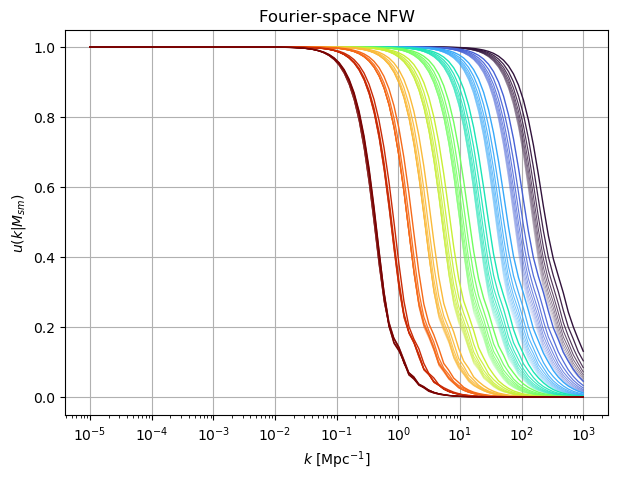

In [84]:
fig, ax = plt.subplots(figsize=(7,5))
colors = plt.cm.turbo(np.linspace(0, 1, nM))

usm_kmz = np.zeros((nk,nM,nz))

for i in range(nM):
    ax.set_xlabel(r'$k\ [{\rm Mpc}^{-1}]$')
    ax.set_ylabel(r'$u(k|M_{sm})$')

    color = colors[i]
    for j,z in enumerate(z_grid):
        alpha = 1 - j / len(z_grid) * 0.8
        lw = 1 - j / len(z_grid) * 0.8
        Msm = Msm_grid[i,j]
        c200, r200, rs = c200_r200_rs(Msm, z=z, hm=hm)
        u = u_nfw(k_grid, c200, rs)
        usm_kmz[:, i, j] = u[:,0] 
        ax.plot(k_grid, usm_kmz[:,i,j], '-',color=color, alpha=alpha, lw=lw)
        ax.set_xscale('log')
    ax.plot([], [], '-', color=color)

#ax.legend(title='Smooth Mass', loc='lower left')    
plt.title('Fourier-space NFW')
plt.grid()
plt.show()

$$\bar{\rho}(z) = \int_0^\infty Mn(M,z)b(M,z))= \int_0^\infty \frac{M_{sm}}{1+f_{sub}(z)} n(M,z)b(M,z))$$

$$n(M,z) -> n(M,z)\Theta (M-M_{min}) + \frac{\delta_D(M-M_{min})A(M_{min})}{b(M_{min})M_{min}/\bar{\rho}}$$

$$A(M_{min}) = 1 - \frac{\bar{\rho_b}}{\bar{\rho}}$$

for $M<M_{min}$, $f_{sub}=0$ -> Change the integrals to standard halo model integrals at $M=M_{min}$

In [100]:
Mmin_normalization = True 
P_1ss = np.zeros((nz, nk))
P_1sc = np.zeros((nz, nk))
P_1cc = np.zeros((nz, nk))
P_1self_c = np.zeros((nz, nk))

for z_id in range(nz):
    for k_id in range(nk):
        M = M_grid
        Ms = Msm_grid[:, z_id]

        dndlnM = dndlnM_mz[:, z_id]

        u = u_kmz[k_id, :, z_id]
        usm = usm_kmz[k_id, :, z_id]

        I = I_kmz[k_id, :, z_id]
        J = J_kmz[k_id, :, z_id]

        A = (M / rho_comoving)**2 * dndlnM

        integrand_ss = A * (Ms / M)**2 * usm**2
        integrand_sc = A * Ms / M * usm * u * I
        integrand_cc = A * u**2 * I**2
        integrand_self_c = A * J

        if Mmin_normalization:
            B = rho_comoving / Mmin / b_mz[0, z_id]  * (1 - rho_b[z_id] / rho_comoving) 
            P_1ss[z_id, k_id] = simpson(integrand_ss, lnM) + integrand_ss[0] * B
            P_1sc[z_id, k_id] = 2 * (simpson(integrand_sc, lnM) + integrand_sc[0] * B)
            P_1cc[z_id, k_id] = simpson(integrand_cc, lnM) + integrand_cc[0] * B
            P_1self_c[z_id, k_id] = simpson(integrand_self_c, lnM) + integrand_self_c[0] * B
        else:
            P_1ss[z_id, k_id] = simpson(integrand_ss, lnM) 
            P_1sc[z_id, k_id] = 2 * simpson(integrand_sc, lnM)
            P_1cc[z_id, k_id] = simpson(integrand_cc, lnM)
            P_1self_c[z_id, k_id] = simpson(integrand_self_c, lnM)

P_1h_total = P_1ss + P_1sc + P_1cc + P_1self_c


In [101]:
P_2ss = np.zeros((nz, nk))
P_2sc = np.zeros((nz, nk))
P_2cc = np.zeros((nz, nk))

for z_id in range(nz):
    for k_id in range(nk):
        M = M_grid
        Ms = Msm_grid[:, z_id]

        dndlnM = dndlnM_mz[:, z_id]

        b = b_mz[:, z_id]

        I = I_kmz[k_id, :, z_id]

        u = u_kmz[k_id, :, z_id]
        usm = usm_kmz[k_id, :, z_id]

        Plin = P_lin_zk[z_id,k_id]

        integrand_S = (M / rho_comoving) * dndlnM * b * (Ms / M) * usm
        integrand_C = (M / rho_comoving) * dndlnM * b * u  * I

        S = simpson(integrand_S, lnM)
        C = simpson(integrand_C, lnM)
        
        if Mmin_normalization:
            B = rho_comoving/Mmin /b_mz[0,z_id] * (1 - rho_b[z_id] / rho_comoving)
            P_2ss[z_id, k_id] = Plin * ( S  + integrand_S[0] * B )** 2
            P_2sc[z_id, k_id] = 2 * Plin * (S + integrand_S[0] * B ) * (C + integrand_C[0] * B)
            P_2cc[z_id, k_id] = Plin * (C + integrand_C[0] * B)** 2 
        else:
            P_2ss[z_id, k_id] = Plin * S** 2
            P_2sc[z_id, k_id] = 2 * Plin * S * C
            P_2cc[z_id, k_id] = Plin * C ** 2

P_2h_total = P_2ss + P_2sc + P_2cc 

In [102]:
P_hh_total_sub = P_1h_total + P_2h_total

In [103]:
# Scale-dependent one-halo suppression like in the normal halo model
for z_id in range(nz):
    P_1ss[z_id,:] *= one_halo_suppression(k_grid, k_star[z_id])
    P_1sc[z_id,:] *= one_halo_suppression(k_grid, k_star[z_id])
    P_1cc[z_id,:] *= one_halo_suppression(k_grid, k_star[z_id])
    P_1self_c[z_id,:] *= one_halo_suppression(k_grid, k_star[z_id])

P_1h_total = P_1ss + P_1sc + P_1cc + P_1self_c
P_hh_total_sub = P_1h_total + P_2h_total

In [104]:
np.savez('halo_model_power_spectra_substructure005.npz', k=k_grid, z=z_grid, P_1ss=P_1ss, P_1sc=P_1sc, P_1cc=P_1cc, P_1self_c=P_1self_c, P_1h_total=P_1h_total,P_2ss=P_2ss, P_2sc=P_2sc, P_2cc=P_2cc, P_2h_total=P_2h_total,P_hh_total=P_hh_total_sub)

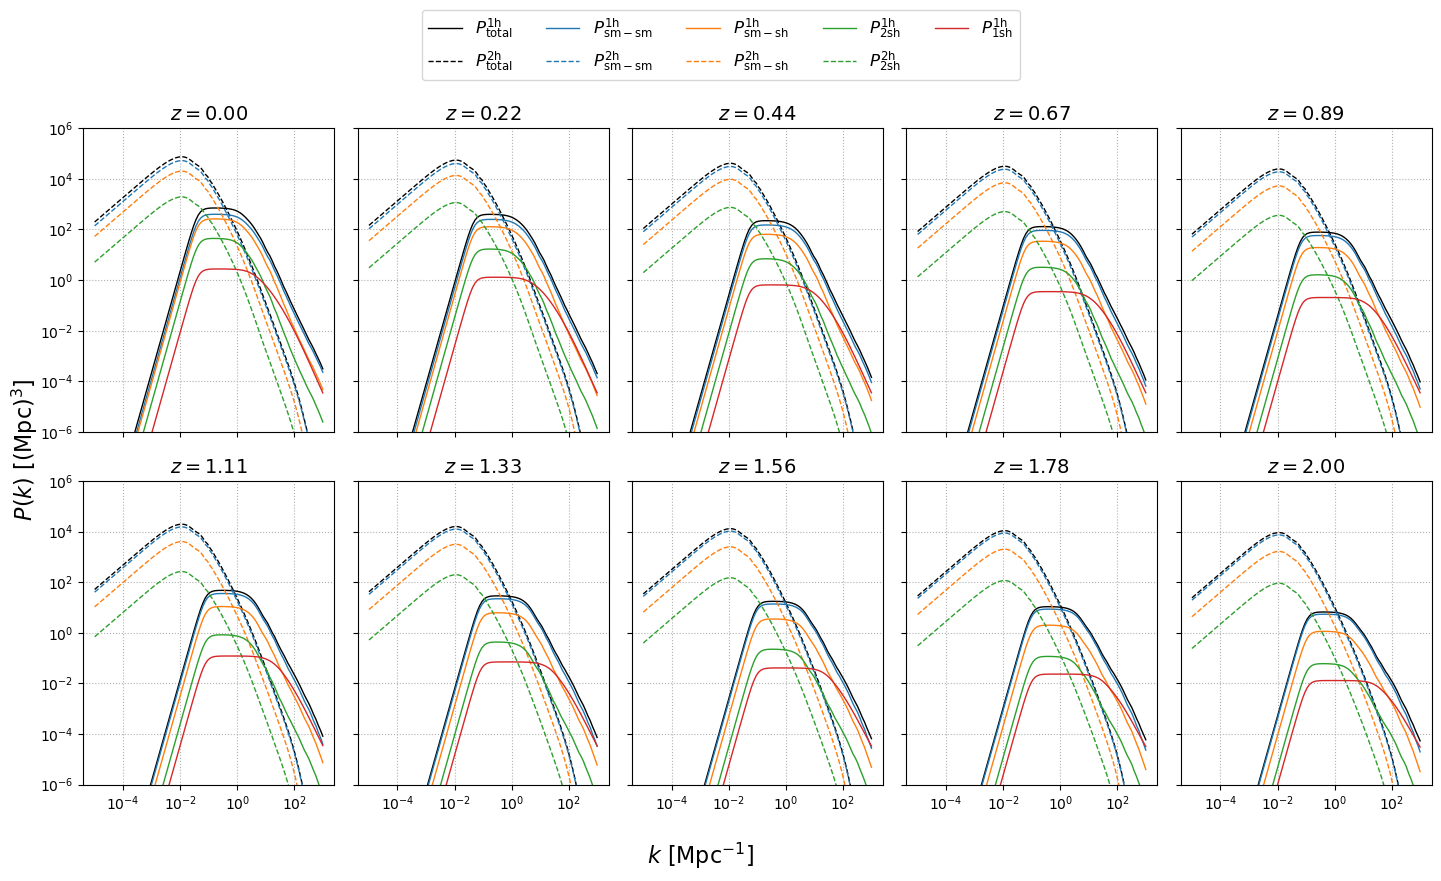

In [62]:
fig, axes = plt.subplots(2, 5, figsize=(15, 9), sharex=True, sharey=True)
axes = axes.flatten()

for i, z in enumerate(z_grid):
    ax = axes[i]

    ax.plot(k_grid, P_1h_total[i,:], color='black', ls='-',linewidth = 1, label=r"$P^{1\mathrm{h}}_{\mathrm{total}}$")

    ax.plot(k_grid, P_2h_total[i,:], color='black', ls='--',linewidth = 1, label=r"$P^{2\mathrm{h}}_{\mathrm{total}}$")

    ax.plot(k_grid, P_1ss[i,:],     color='C0', ls='-',linewidth = 1,     label=r"$P^{1\mathrm{h}}_{\mathrm{sm-sm}}$")

    ax.plot(k_grid, P_2ss[i,:],     color='C0', ls='--',linewidth = 1,     label=r"$P^{2\mathrm{h}}_{\mathrm{sm-sm}}$")

    ax.plot(k_grid, P_1sc[i,:],     color='C1', ls='-',linewidth = 1,     label=r"$P^{1\mathrm{h}}_{\mathrm{sm-sh}}$")

    ax.plot(k_grid, P_2sc[i,:],     color='C1', ls='--',linewidth = 1,     label=r"$P^{2\mathrm{h}}_{\mathrm{sm-sh}}$")

    ax.plot(k_grid, P_1cc[i,:],     color='C2', ls='-',linewidth = 1,     label=r"$P^{1\mathrm{h}}_{\mathrm{2sh}}$")
    ax.plot(k_grid, P_2cc[i,:],     color='C2', ls='--',linewidth = 1,     label=r"$P^{2\mathrm{h}}_{\mathrm{2sh}}$")

    ax.plot(k_grid, P_1self_c[i,:], color='C3', ls='-',linewidth = 1, label=r"$P^{1\mathrm{h}}_{\mathrm{1sh}}$")

    # --- standard 1-halo and 2-halo ---
    #ax.plot(k_grid, P_1h[i,:], ls='-', color='m', linewidth = 0.7,label=r"$P_{1\mathrm{h}}$ (standard)")
    #ax.plot(k_grid, P_2h[i,:], ls='-', color='m', linewidth = 0.7, label=r"$P_{2\mathrm{h}}$ (standard)")

    # --- Linear power spectrum ---
   # ax.plot(k_grid, P_lin_zk[i,:], ls='-', color='c',linewidth = 1, label=r"$P_{m\mathrm{,linear}}$")


    # --- Axis formatting ---
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(1e-6, 1e6)
    ax.set_title(fr"$z = {z:.2f}$", fontsize=14)
    ax.grid(True, which="both", ls=":")

# --- Turn off any unused panels (none here) ---
for j in range(len(z_grid), len(axes)):
    axes[j].axis("off")

# --- Shared axis labels ---
fig.text(0.5, 0.04, r"$k\ [{\rm Mpc}^{-1}]$", ha="center", fontsize=16)
fig.text(0.04, 0.5, r"$P_{\rm}(k)\ [(\mathrm{Mpc})^3]$", va="center",
         rotation="vertical", fontsize=16)

# --- One clean shared legend ---
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=5,
           fontsize=12, frameon=True, borderaxespad=0.6)

plt.tight_layout(rect=[0.05, 0.08, 1, 0.90])
plt.show()


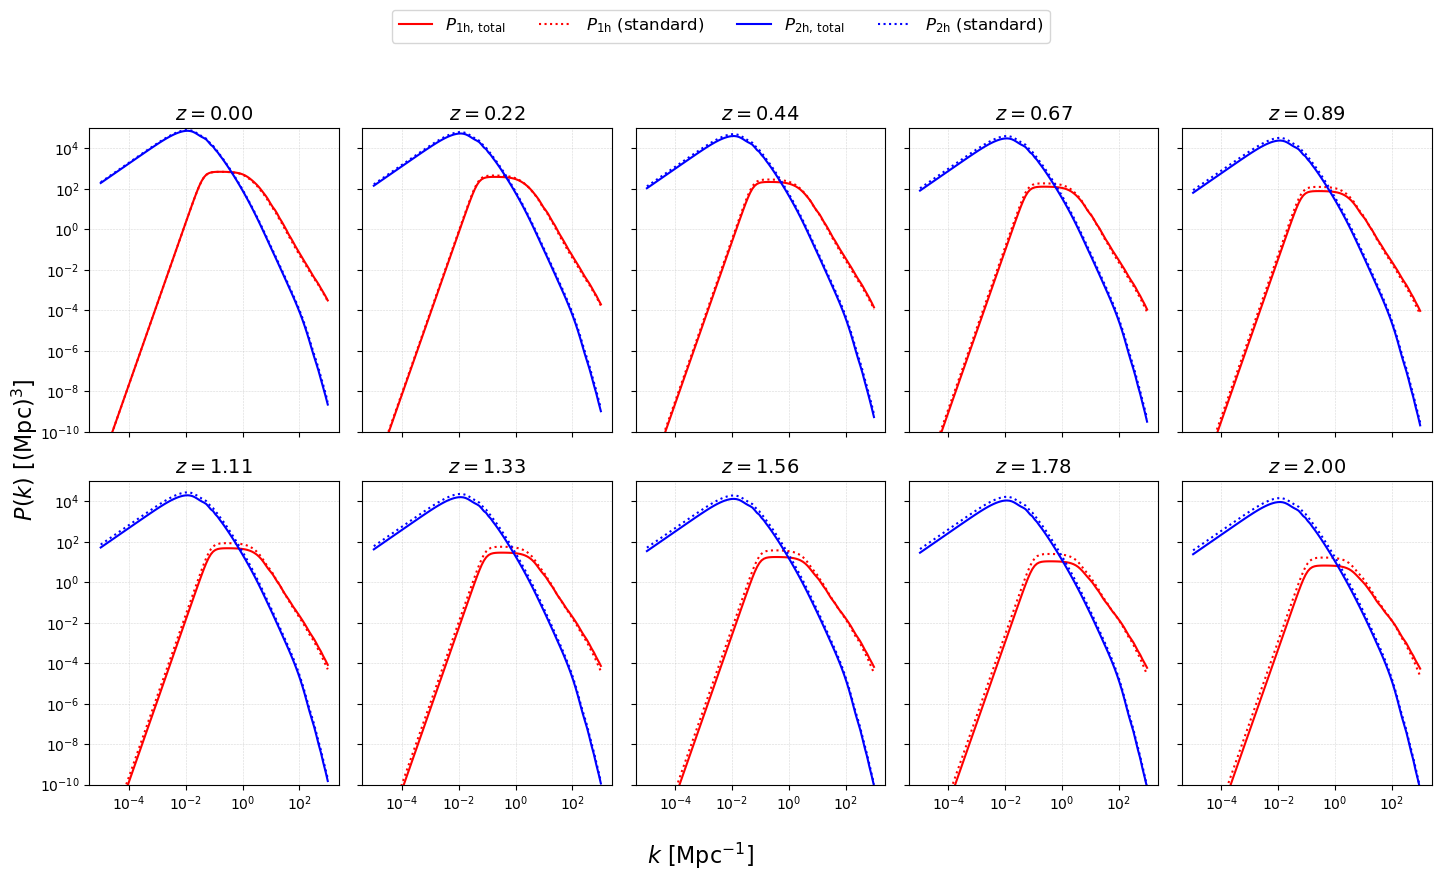

In [64]:
fig, axes = plt.subplots(2, 5, figsize=(15, 9), sharex=True, sharey=True)
axes = axes.flatten()

for i, z in enumerate(z_grid):
    ax = axes[i]

    # --- Total 1-halo ---
    ax.plot(k_grid, P_1h_total[i,:], color='r', ls='-', label=r"$P_{1\mathrm{h,\,total}}$")

    # --- standard 1-halo  ---
    ax.plot(k_grid, P_1h[i,:], ls=':', color='r', label=r"$P_{1\mathrm{h}}$ (standard)")

        # --- Total 2-halo ---
    ax.plot(k_grid, P_2h_total[i,:], color='b', ls='-', label=r"$P_{2\mathrm{h,\,total}}$")

    # --- standard 2-halo  ---
    ax.plot(k_grid, P_2h[i,:], ls=':', color='b', label=r"$P_{2\mathrm{h}}$ (standard)")

    # --- Axis formatting ---
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(1e-10, 1e5)
    ax.set_title(fr"$z = {z:.2f}$", fontsize=14)
    ax.grid(True, which="both", ls="--", lw=0.4, alpha=0.5)

# --- Turn off any unused panels (none here) ---
for j in range(len(z_grid), len(axes)):
    axes[j].axis("off")

# --- Shared axis labels ---
fig.text(0.5, 0.04, r"$k\ [{\rm Mpc}^{-1}]$", ha="center", fontsize=16)
fig.text(0.04, 0.5, r"$P_{\rm}(k)\ [(\mathrm{Mpc})^3]$", va="center",
         rotation="vertical", fontsize=16)

# --- One clean shared legend ---
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=5,
           fontsize=12, frameon=True, borderaxespad=0.6)

plt.tight_layout(rect=[0.05, 0.08, 1, 0.90])
plt.show()

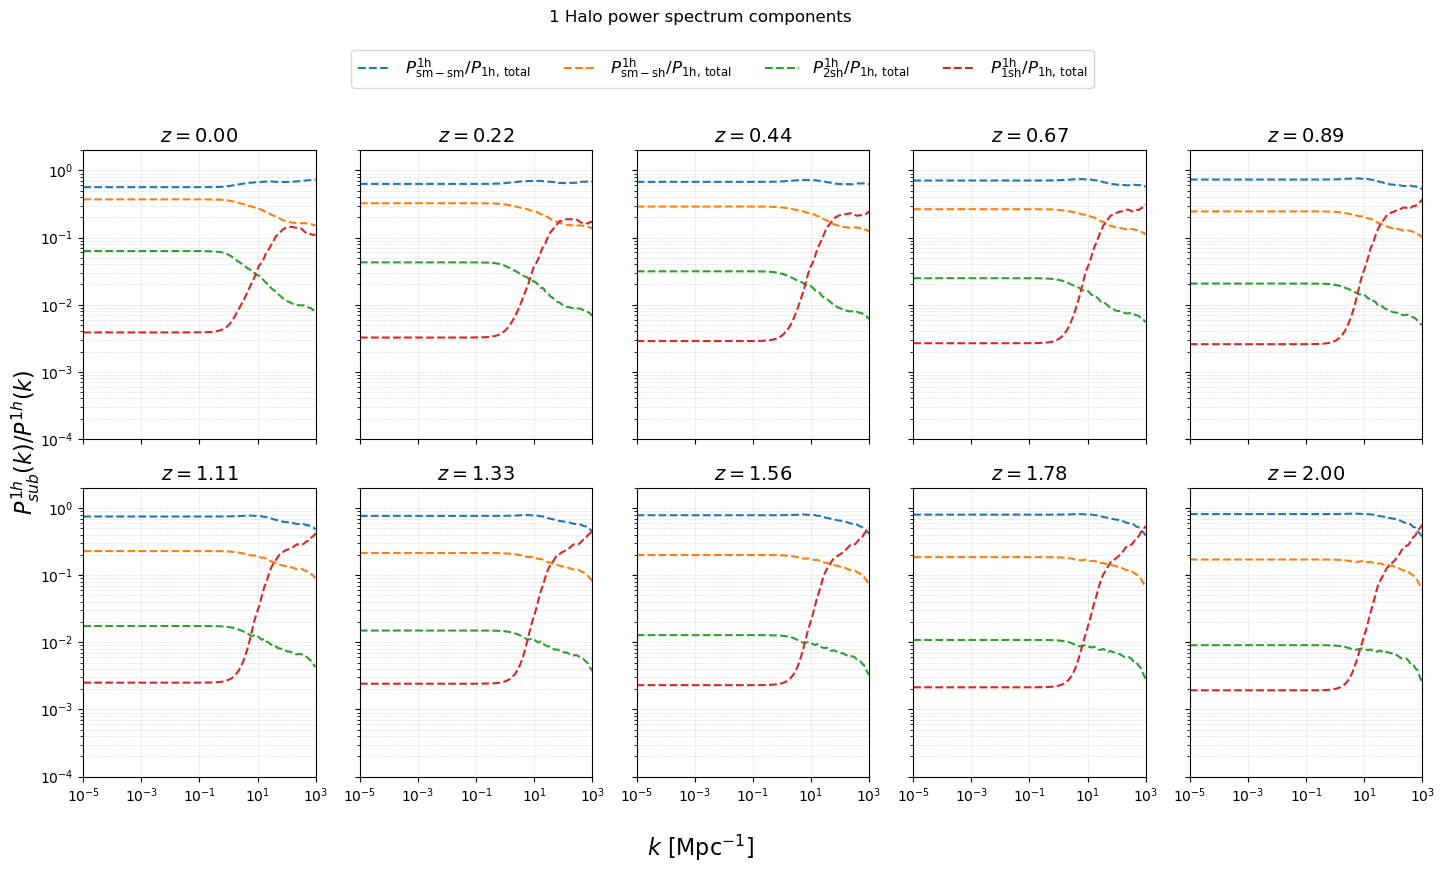

In [56]:
fig, axes = plt.subplots(2, 5, figsize=(15, 9), sharex=True, sharey=True)
fig.suptitle('1 Halo power spectrum components')

axes = axes.flatten()

for i, z in enumerate(z_grid):
    ax = axes[i]

    # --- Plot each 1-halo component ---
    ax.plot(k_grid, P_1ss[i,:]/P_1h_total[i,:],     color='C0', ls='--',     label=r"$P^{1\mathrm{h}}_{\mathrm{sm-sm}}/P_{1\mathrm{h,\,total}}$")
    ax.plot(k_grid, P_1sc[i,:]/P_1h_total[i,:],     color='C1', ls='--',     label=r"$P^{1\mathrm{h}}_{\mathrm{sm-sh}}/P_{1\mathrm{h,\,total}}$")
    ax.plot(k_grid, P_1cc[i,:]/P_1h_total[i,:],     color='C2', ls='--',     label=r"$P^{1\mathrm{h}}_{\mathrm{2sh}}/P_{1\mathrm{h,\,total}}$")
    ax.plot(k_grid, P_1self_c[i,:]/P_1h_total[i,:], color='C3', ls='--', label=r"$P^{1\mathrm{h}}_{\mathrm{1sh}}/P_{1\mathrm{h,\,total}}$")

    # --- Axis formatting ---
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(1e-4, 2)
    ax.set_xlim(kmin, kmax)
    ax.set_title(fr"$z = {z:.2f}$", fontsize=14)
    ax.grid(True, which="both", ls="--", lw=0.4, alpha=0.5)

# --- Turn off any unused panels (none here) ---
for j in range(len(z_grid), len(axes)):
    axes[j].axis("off")

# --- Shared axis labels ---
fig.text(0.5, 0.04, r"$k\ [{\rm Mpc}^{-1}]$", ha="center", fontsize=16)
fig.text(0.04, 0.5, r'$P^{1h}_{sub}(k) /P^{1h}(k)$', va="center",
         rotation="vertical", fontsize=16)

# --- One clean shared legend ---
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=5,
           fontsize=12, frameon=True, borderaxespad=3)

plt.tight_layout(rect=[0.05, 0.08, 1, 0.90])
plt.show()

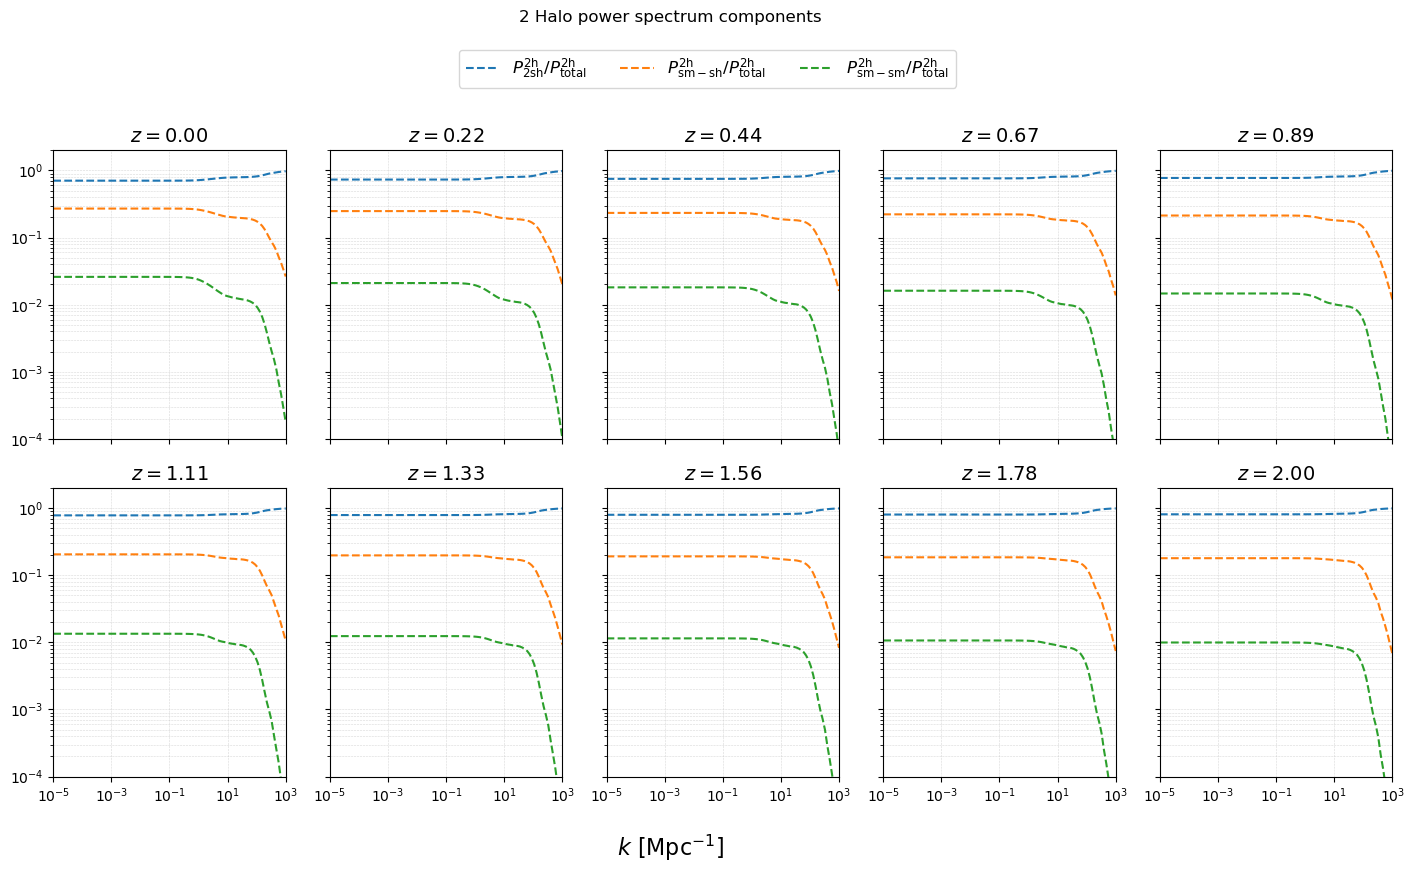

In [57]:
fig, axes = plt.subplots(2, 5, figsize=(15, 9), sharex=True, sharey=True)
fig.suptitle('2 Halo power spectrum components')

axes = axes.flatten()

for i, z in enumerate(z_grid):
    ax = axes[i]

    # --- Plot each 2-halo component ---
    ax.plot(k_grid, P_2ss[i,:]/P_2h_total[i,:],     color='C0', ls='--',     label=r"$P^{2\mathrm{h}}_{\mathrm{2sh}}/P^{2\mathrm{h}}_{\mathrm{total}}$")
    ax.plot(k_grid, P_2sc[i,:]/P_2h_total[i,:],     color='C1', ls='--',     label=r"$P^{2\mathrm{h}}_{\mathrm{sm-sh}}/P^{2\mathrm{h}}_{\mathrm{total}}$")
    ax.plot(k_grid, P_2cc[i,:]/P_2h_total[i,:],     color='C2', ls='--',     label=r"$P^{2\mathrm{h}}_{\mathrm{sm-sm}}/P^{2\mathrm{h}}_{\mathrm{total}}$")

    # --- Axis formatting ---
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(1e-4, 2)
    ax.set_xlim(kmin, kmax)
    ax.set_title(fr"$z = {z:.2f}$", fontsize=14)
    ax.grid(True, which="both", ls="--", lw=0.4, alpha=0.5)

# --- Turn off any unused panels (none here) ---
for j in range(len(z_grid), len(axes)):
    axes[j].axis("off")

# --- Shared axis labels ---
fig.text(0.5, 0.04, r"$k\ [{\rm Mpc}^{-1}]$", ha="center", fontsize=16)
#fig.text(0.04, 0.5, r'$P^{2h}_{sub}(k) /P^{2h}(k)$', va="center",
 #        rotation="vertical", fontsize=16)

# --- One clean shared legend ---
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=5,
           fontsize=12, frameon=True, borderaxespad=3)

plt.tight_layout(rect=[0.05, 0.08, 1, 0.90])
plt.show()